# Image to world coordinate mapper

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16, 12)
from skimage.exposure import histogram
import numpy as np

from mapper import Mapper, ImageProcessor

## Process the image and extract positions

In [3]:
ip = ImageProcessor("test/Pickolo_2021-08-02T15-40-55_384-Point_Calibration_Plate.jpg")

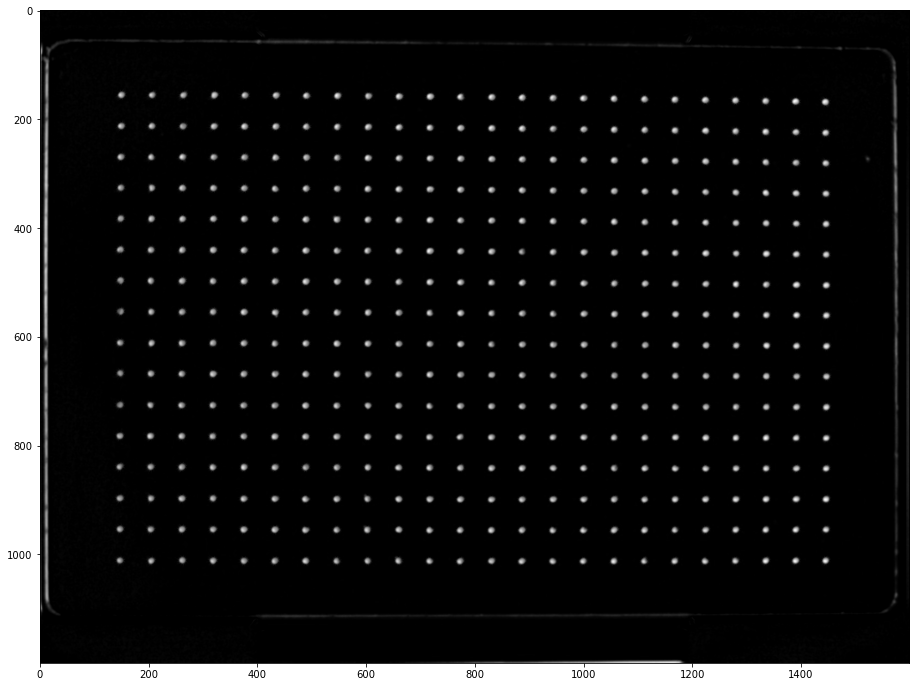

In [4]:
# Show the prepared image
plt.imshow(ip.image, cmap='gray');

In [5]:
# Extract the calibration points
ip.process()

In [6]:
# Save the results
ip.save('coordinates.pck')

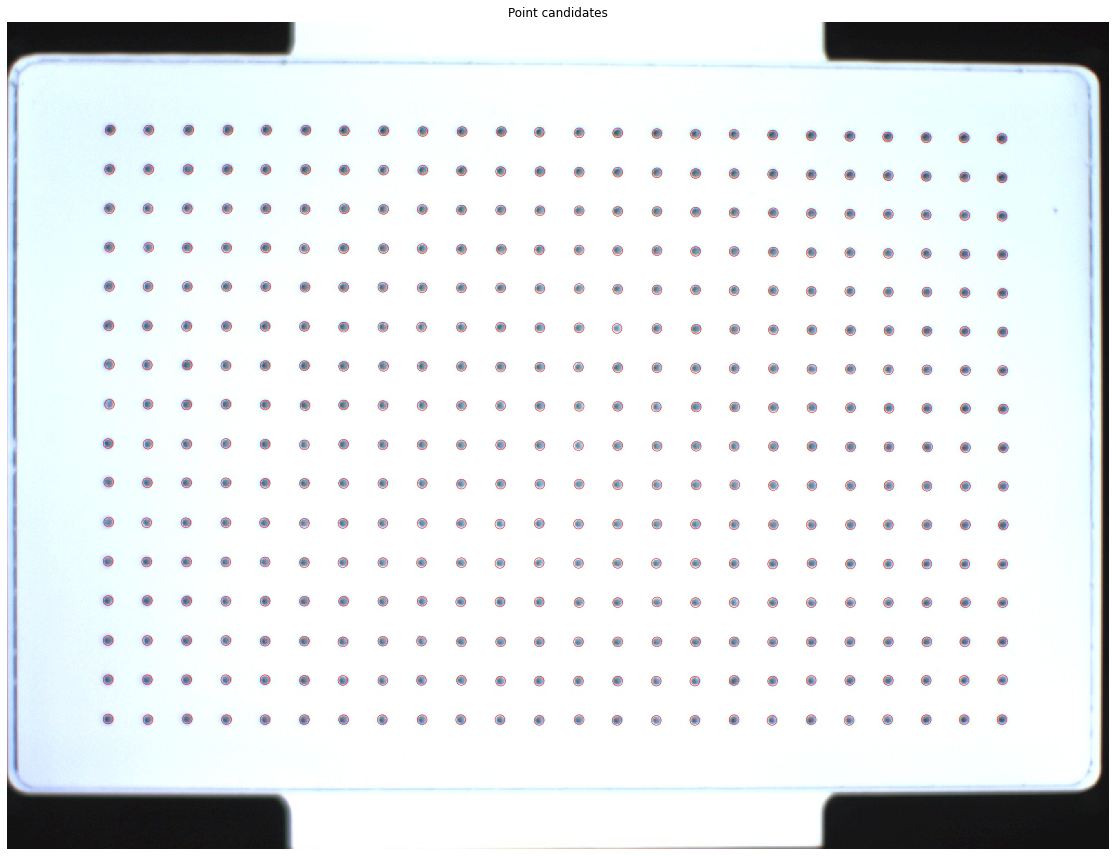

In [7]:
# Plot (and save) current results.
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.set_title('Point candidates')
ax.imshow(ip.raw_image, interpolation='nearest')
for blob, r in zip(ip.points, ip.radii):
    y, x = blob
    c = plt.Circle((x, y), r, color="red", linewidth=0.5, fill=False)
    ax.add_patch(c)
    ax.set_axis_off()
fig.tight_layout()
fig.savefig("result_lg.png", dpi=300)

## Calibrate the system using the extracted points

In [8]:
mapper = Mapper(ip.points)

In [9]:
# Calibrate
mapper.calibrate()

Optimization terminated successfully.
         Current function value: 0.003404
         Iterations: 46
         Function evaluations: 90


### Transform without grid correction

In [10]:
# Mapper transform (no grid correction)
opt_points_no_corr = mapper.list_transform(ip.points, apply_grid_correction=False)

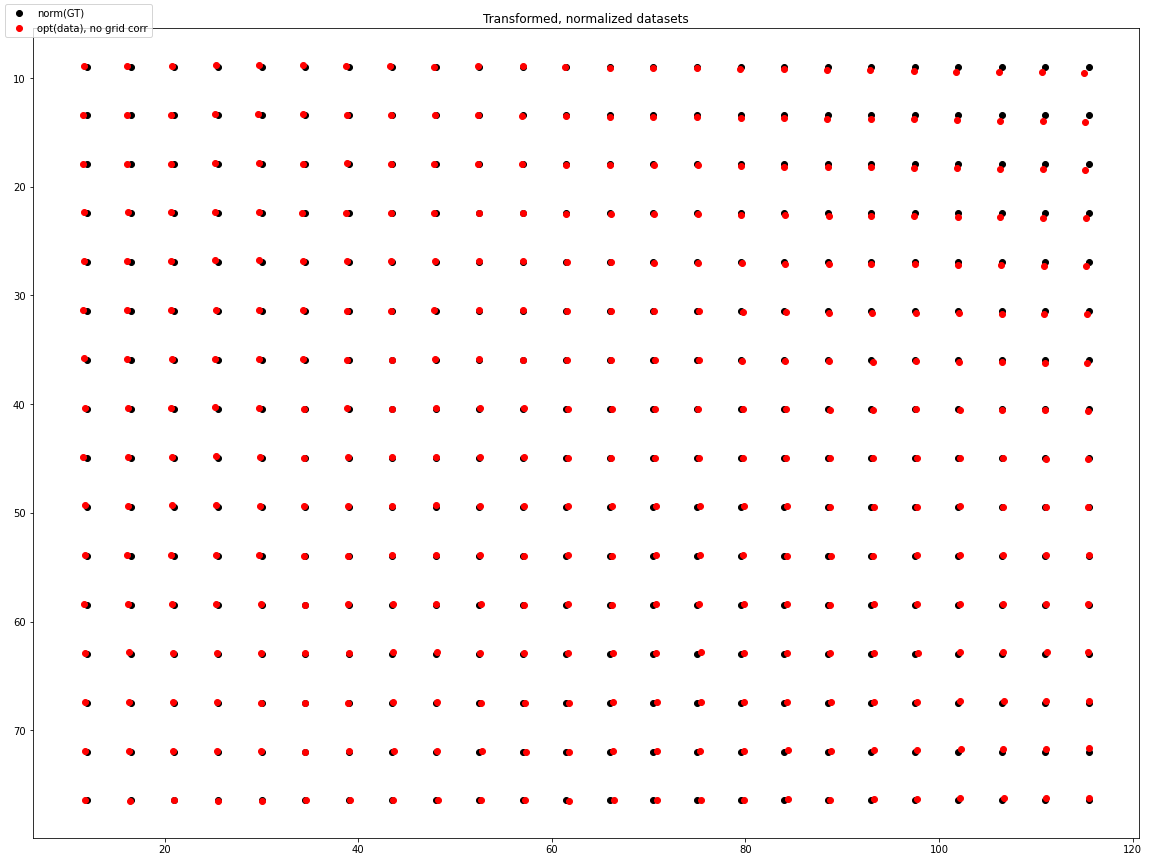

In [11]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.set_title('Transformed, normalized datasets')
ax.plot(mapper.gt[:, 1], mapper.gt[:, 0], 'ko', label="norm(GT)")
ax.plot(opt_points_no_corr[:, 1], opt_points_no_corr[:, 0], 'ro', label="opt(data), no grid corr")
ax.invert_yaxis()
fig.tight_layout()
fig.legend(loc="upper left");

In [12]:
# Get the distribution of errors
d_no_corr = mapper.calc_distances(mapper.gt, opt_points_no_corr)

In [13]:
hist_no_corr = histogram(d_no_corr, nbins=25)

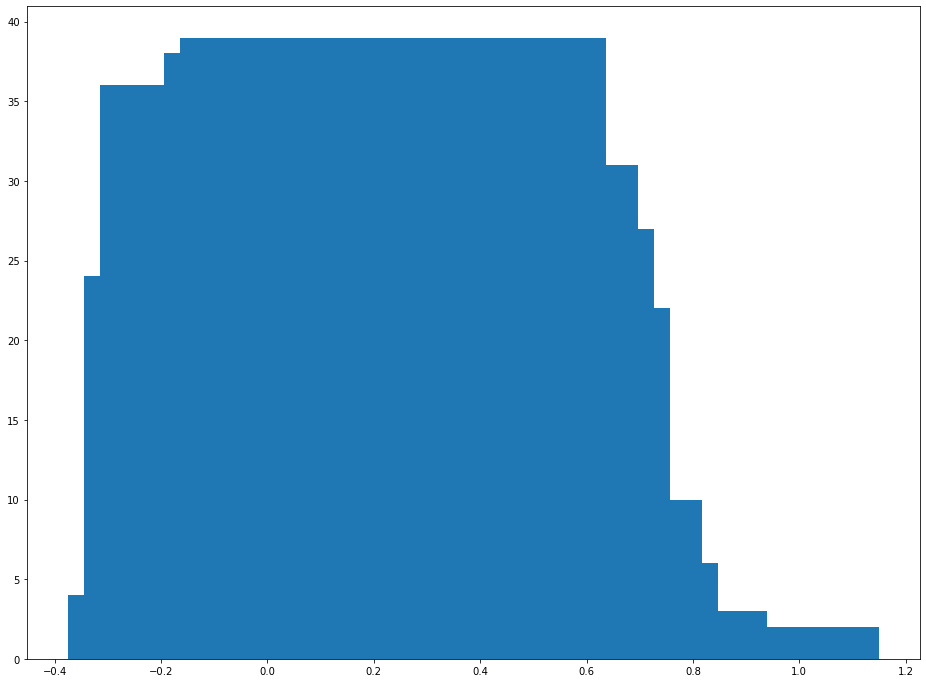

In [14]:
plt.bar(hist_no_corr[1], hist_no_corr[0]);

### Transform with grid correction

In [15]:
# Mapper transform (with grid correction)
opt_points = mapper.list_transform(ip.points)  # Grid correction is default

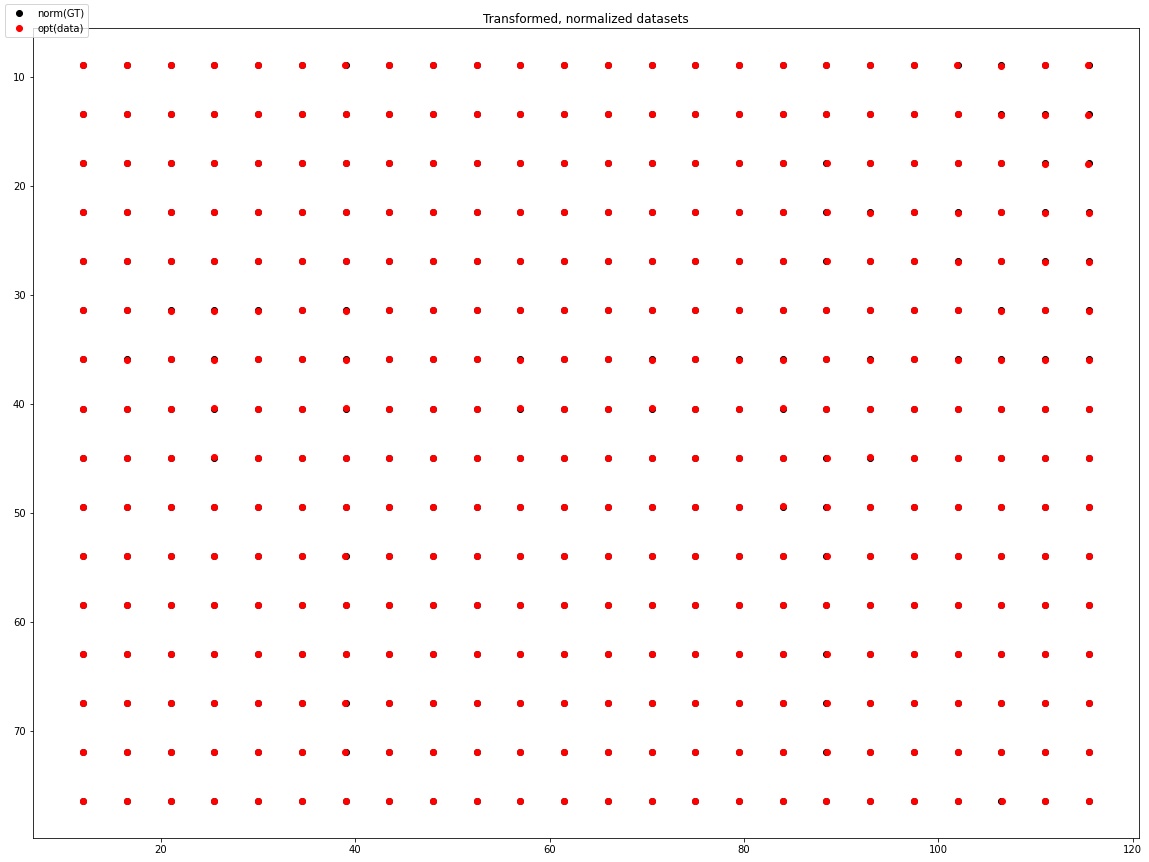

In [16]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.set_title('Transformed, normalized datasets')
ax.plot(mapper.gt[:, 1], mapper.gt[:, 0], 'ko', label="norm(GT)")
ax.plot(opt_points[:, 1], opt_points[:, 0], 'ro', label="opt(data)")
ax.invert_yaxis()
fig.tight_layout()
fig.legend(loc="upper left");

In [17]:
# Get the distribution of errors
d = mapper.calc_distances(mapper.gt, opt_points)

In [18]:
hist = histogram(d, nbins=25)

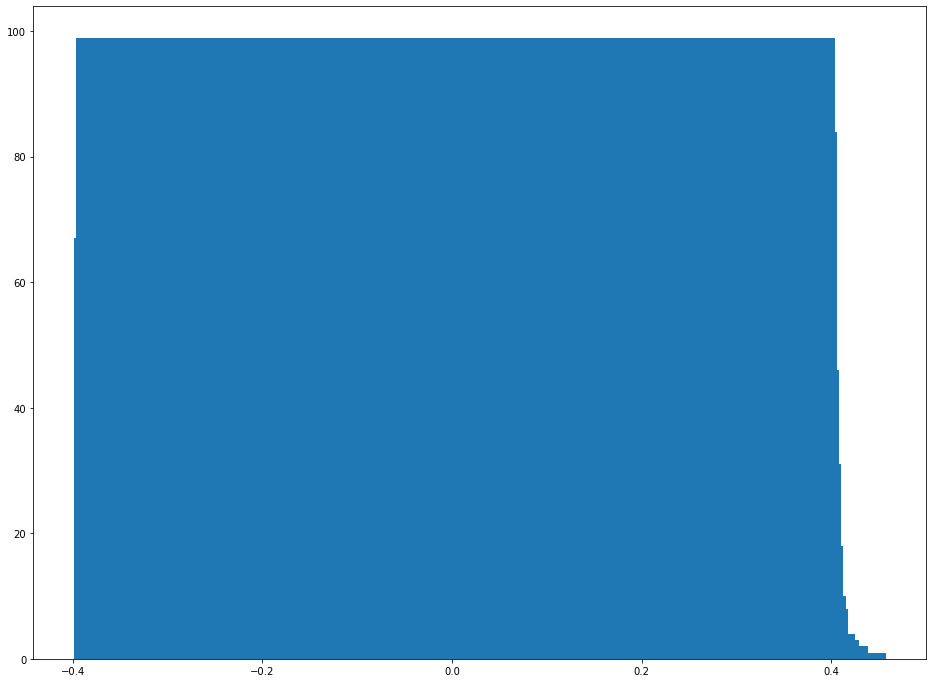

In [19]:
plt.bar(hist[1], hist[0]);

## Save and reload the calibration

In [20]:
# Save the calibration to file 'calibration.clb'
mapper.save("calibration.clb")

True

In [21]:
# Reload the calibration file (it will be applied to current mapper)
mapper.load("calibration.clb")

True

In [22]:
# Transform a point with reloaded calibration
print(mapper.point_transform(ip.points[0, 0], ip.points[0, 1]))

(8.95, 12.0)


## Create a Mapper passing a calibration file to the constructor.

In [23]:
mapper_c = Mapper(calibration_file_name="calibration.clb")

In [27]:
# Transform a point with reloaded calibration
print(mapper_c.point_transform(ip.points[0, 0], ip.points[0, 1]))

(8.95, 12.0)


## Create an uncalibrated Mapper and then load the calibration

In [28]:
# Now create a Mapper without passing any points and any calibration files
mapper_e = Mapper()

In [29]:
# Load calibration
mapper_e.load("calibration.clb")

True

In [30]:
# Transform a point with reloaded calibration
print(mapper_e.point_transform(ip.points[0, 0], ip.points[0, 1]))

(8.95, 12.0)
